In [1]:
import numpy as np
import pandas as pd
import random
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
class city():
    def __init__(self,name,x,y):
        self.name=name
        self.x=x
        self.y=y
        
    def __repr__(self):
        print(self.name,self.x,self.x)
        return ''

In [3]:
class chromosome:
    def __init__(self, lst):
        self.path = lst
        self.fitness = -1
        self.cost = -1
    
    def __repr__(self):
        print(self.path,self.cost)
        return ''

In [4]:
def calc_dist(p1,p2):
    return np.sqrt((p1.x-p2.x)**2+(p1.y-p2.y)**2)

In [5]:
def calc_cost(crom, mat):
    total_cost = 0
    lst = crom.path
    n=len(lst)
    # sum up the distances between each two adjacent genes
    for i in range(1,n):
        total_cost += mat[lst[i].name][lst[i-1].name]
    
    total_cost += mat[lst[0].name][lst[-1].name]
    return total_cost

In [6]:
def gen_dist_matrix(data):
    n = len(data)
    mat = {}   
    for point in data: 
        key = point.name
        mat[key] = {}
        # for each data point calc the distance between it and all the other points
        for j in range(n):
            p2 = data[j]
            c = p2.name
            mat[key][c] = calc_dist(point,p2)
                
    return mat

# Genetic Algorithm

In [7]:
def fitness_score(population):
    scores = []
    # calc the cost for each crom in the pop 
    for chromosome in population:
        cost=calc_cost(chromosome)
        scores.append(cost)
       
    scores= np.array(scores)
    
    # get the indeces for the sorted scores accending
    inds = np.argsort(scores)  
    
    # return the scores and pop according to the accending indeces 
    return list(scores[inds]), population[inds]

In [8]:
def selection(population,n):
    # Use K-Tournament Selection and return the fittest one 
    candidates = random.choices(population, k=n)
    return max(candidates, key = lambda x: x.fitness)

In [9]:
def elitism(percent, old_pop):
    n = int(percent*len(old_pop))
    sort = sorted(old_pop, key = lambda x: x.fitness, reverse=True)
    return sort[:n+1]

In [10]:
def partial_crossover(p1, p2, dist_mat):
    ln = len(p1.path)
    # random split range and divid the whole path into 3 ranges
    range1 = random.randrange(ln-1)
    range2 = random.randrange(ln-1)
    
    if range1 > range2:
        range1, range2 = range2, range1
        
    c1 = deepcopy(p1)
    c2 = deepcopy(p2)
    
    # iterate over the between range 
    for index in range(range1, range2+1):
        # (c1 vs p2)
        # look at the value in the opposite index for index in p2   
        # and fing the duplicated value (dup)
        dup = p2.path[index] 
        # find the index of duplicated value in c1 
        dup_index = [d.name for d in c1.path].index(dup.name)
        # swap index and dup_index in c1 
        c1.path[index], c1.path[dup_index] = c1.path[dup_index], c1.path[index]
        
         # (c2 vs p1)
        # look at the value in the opposite index for index in p1   
        # and fing the duplicated value (dup)
        dup = p1.path[index]
        dup_index = [d.name for d in c2.path].index(dup.name)
        # swap index and dup_index in c2
        c2.path[index], c2.path[dup_index] = c2.path[dup_index], c2.path[index]
    
    
    #  calc the cost for the new two croms
    cost1=calc_cost(c1, dist_mat)
    c1.cost=cost1
    c1.fitness=1/cost1
    
    cost2=calc_cost(c2, dist_mat)
    c2.cost=cost2
    c2.fitness=1/cost2
    
    return c1, c2

In [11]:
def crossover(prob,population,dist_mat):
    
    # Use K-Tournament Selection to choose the fittest candidate
    parent1 = selection(population,5)
    parent2 = selection(population,5)
    
    
    #random r for each 2 fittest candidates if r less the crossover pertage then apply crossover
    r = random.random()
    
    # if grater don't apply crossover 
    if r > prob: 
        return parent1,parent2   
    
    #  Use partially mapped Crossover
    c1, c2 = partial_crossover(parent1, parent2, dist_mat)
    if parent1.fitness > c1.fitness:
        c1=parent1
    if parent2.fitness > c2.fitness:
        c2=parent2  
        
    return c1,c2

In [12]:
def mutation(prob, pop, dist_mat):
    new_pop = []
    
    # apply mutation on the whole pop 
    for chrom in pop:
        c = deepcopy(chrom)
        
        # random r for each crom if r less the mutation pertage then apply mutation on this crom
        r = random.random()
        if r < prob: 
            ln = len(chrom.path)
            index1 = random.randrange(ln-1)
            index2 = random.randrange(ln-1)
            
            # use swap mutation
            c.path[index1], c.path[index2] = c.path[index2], c.path[index1]
            
        # calc the cost for the mutated crom
        cost=calc_cost(c, dist_mat)
        c.cost=cost
        c.fitness=1/cost
        
        # add it to the new pop 
        new_pop.append(c)
    return new_pop

In [13]:
def generate(lst_cities, n, dist_mat):
    generation = []
    # create random croms
    for i in range(n):
        crom = lst_cities.copy()
        random.shuffle(crom)
        
        c = chromosome(crom)
        # calculate the cost for the created crom path
        cost = calc_cost(c, dist_mat)
        
        c.cost=cost
        c.fitness=1/cost
        # add the crom to the pop
        generation.append(c)
        
    return generation

In [14]:
def generations(data,size=50,cross_over_rate=0.6,mutation_rate=0.1,elitism_per=0.1,gen_num=100):
    best_chromo= []
    best_score= []
    # 1- generate distance matrix
    dist_mat = gen_dist_matrix(data)
    
    # 2- generate intial population
    population=generate(data,size,dist_mat)
    
    n=len(population)
    for i in range(gen_num):
        new_pop=[]
       # add elitism to the new pop
    
        new_pop= elitism(elitism_per, population) 
        while(len(new_pop)<n):
            
            # apply crossover untill new pop size reach the old pop size
            new_child1,new_child2=crossover(cross_over_rate,population,dist_mat)
            new_pop.append(new_child1)
            new_pop.append(new_child2)
            
        if len(new_pop) != n:
            new_pop.pop()
        
        # apply mutation on the new pop 
        new_pop=mutation(mutation_rate, new_pop, dist_mat)
       
       # update pop 
        population=new_pop
    
    return population


# Read data here

In [15]:
df=pd.read_csv('15-Points.csv')
df

,x,y,City
0,5.500000e-08,9.860000e-09,1
1,-2.887330e+01,-7.980000e-08,2
2,-7.929160e+01,-2.140330e+01,3
3,-1.465770e+01,-4.338960e+01,4
4,-6.474730e+01,2.189820e+01,5
5,-2.905850e+01,-4.321670e+01,6
6,-7.207850e+01,1.815810e-01,7
7,-3.603660e+01,-2.161350e+01,8
8,-5.048080e+01,7.374470e+00,9
9,-5.058590e+01,-2.158820e+01,10


In [16]:
data = [city(c,x,y) for c,x,y in zip(df['City'], df['x'], df['y'])]

In [17]:
size=50
cross_over_rate=0.6
mutation_rate=0.1
elitism_per=0.02
gen_num=100

generation=generations(data,size,cross_over_rate,mutation_rate,elitism_per,gen_num)
    

In [18]:
best = max(generation, key = lambda x: x.fitness)

In [20]:
best.path.append(best.path[0])

In [21]:
for a in best.path:
    print(a.name,'-> ',end='')

10 -> 8 -> 6 -> 4 -> 11 -> 1 -> 13 -> 2 -> 15 -> 9 -> 5 -> 7 -> 3 -> 14 -> 12 -> 10 -> 

In [22]:
print('Cost is : ',best.cost)

Cost is :  292.50579675888645


In [23]:
def plot_cities(cities):
    # Extract x and y coordinates into separate lists
    x_coords = [city.x for city in cities.path]
    y_coords = [city.y for city in cities.path]

    # Create a Matplotlib figure
    fig, ax = plt.subplots()

    # Plot cities as scatter points
    ax.scatter(x_coords, y_coords)

    # Plot path between cities as lines
    for i in range(len(cities.path)-1):
        curr_city = cities.path[i]
        next_city = cities.path[i+1]
        ax.plot([curr_city.x, next_city.x], [curr_city.y, next_city.y],marker='>')

    # Show the plot
    plt.show()

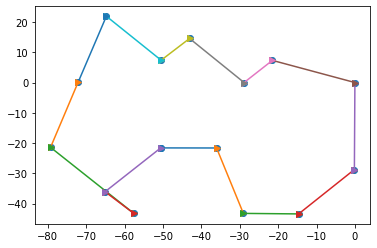

In [24]:
plot_cities(best)